In [1]:
import os

import torch
import torch.optim as optim
from torch.nn import CrossEntropyLoss
from torch.nn import functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader
# os.environ['http_proxy'] = 'http://10.16.35.10:13390' 
# os.environ['https_proxy'] = 'http://10.16.35.10:13390' 

os.environ["WANDB_API_KEY"] = "KEY"
os.environ["WANDB_MODE"] = 'offline'
from itertools import combinations

import clip
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torchvision.transforms as transforms
import tqdm
from eegdatasets_leaveone import EEGDataset
from eegencoder import eeg_encoder
from einops.layers.torch import Rearrange, Reduce
from lavis.models.clip_models.loss import ClipLoss
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader, Dataset
import random
from utils import wandb_logger
from torch import Tensor
import math
    

In [2]:
import os
# os.environ['http_proxy'] = 'http://10.16.35.10:13390' 
# os.environ['https_proxy'] = 'http://10.16.35.10:13390' 
# os.environ["CUDA_VISIBLE_DEVICES"] = "5" 
# os.environ['PATH'] += os.pathsep + '/usr/local/texlive/2023/bin/x86_64-linux'

import torch
from torch import nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import open_clip
from matplotlib.font_manager import FontProperties

import sys
from diffusion_prior import *
from custom_pipeline import *


Load eeg and image embeddings

In [3]:
emb_img_test = torch.load('variables/ViT-H-14_features_test.pt')
emb_img_train = torch.load('variables/ViT-H-14_features_train.pt')

# torch.save(emb_img_test.cpu().detach(), 'variables/ViT-H-14_features_test.pt')
# torch.save(emb_img_train.cpu().detach(), 'variables/ViT-H-14_features_train.pt')

In [4]:
emb_img_test.shape, emb_img_train.shape

(torch.Size([200, 1024]), torch.Size([16540, 1024]))

In [5]:
# 1654clsx10imgsx4trials=66160
emb_eeg = torch.load('/home/ldy/Workspace/Reconstruction/ATM_S_eeg_features_sub-08_train.pt')

emb_eeg_test = torch.load('/home/ldy/Workspace/Reconstruction/ATM_S_eeg_features_sub-08_test.pt')

In [6]:
emb_eeg.shape, emb_eeg_test.shape

(torch.Size([66160, 1024]), torch.Size([200, 1024]))

Training prior diffusion

In [7]:

class EmbeddingDataset(Dataset):

    def __init__(self, c_embeddings=None, h_embeddings=None, h_embeds_uncond=None, cond_sampling_rate=0.5):
        self.c_embeddings = c_embeddings
        self.h_embeddings = h_embeddings
        self.N_cond = 0 if self.h_embeddings is None else len(self.h_embeddings)
        self.h_embeds_uncond = h_embeds_uncond
        self.N_uncond = 0 if self.h_embeds_uncond is None else len(self.h_embeds_uncond)
        self.cond_sampling_rate = cond_sampling_rate

    def __len__(self):
        return self.N_cond

    def __getitem__(self, idx):
        return {
            "c_embedding": self.c_embeddings[idx],
            "h_embedding": self.h_embeddings[idx]
        }

In [8]:
emb_img_train_4 = emb_img_train.view(1654,10,1,1024).repeat(1,1,4,1).view(-1,1024)

In [9]:
emb_img_train_4.shape

torch.Size([66160, 1024])

In [10]:
from torch.utils.data import DataLoader
dataset = EmbeddingDataset(
    c_embeddings=emb_eeg, h_embeddings=emb_img_train_4, 
    # h_embeds_uncond=h_embeds_imgnet
)
print(len(dataset))
dataloader = DataLoader(dataset, batch_size=1024, shuffle=True, num_workers=64)

66160


In [11]:
# device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

# diffusion_prior = DiffusionPrior(dropout=0.1)
diffusion_prior = DiffusionPriorUNet(cond_dim=1024, dropout=0.1)
# number of parameters
print(sum(p.numel() for p in diffusion_prior.parameters() if p.requires_grad))
pipe = Pipe(diffusion_prior, device=device)

9675648


In [12]:
# load pretrained model
model_name = 'diffusion_prior' # 'diffusion_prior_vice_pre_imagenet' or 'diffusion_prior_vice_pre'
pipe.diffusion_prior.load_state_dict(torch.load(f'./ckpts/{model_name}_0_1000.pt', map_location=device))
# pipe.train(dataloader, num_epochs=150, learning_rate=1e-3) # to 0.142 
# torch.save(pipe.diffusion_prior.state_dict(), f'./ckpts/{model_name}_0_1000.pt')

<All keys matched successfully>

In [13]:
seed_value = 42

torch.manual_seed(seed_value)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed_value)

from IPython.display import Image, display
generator = Generator4Embeds(num_inference_steps=4, device=device)

gen = torch.Generator(device=device)
gen.manual_seed(seed_value)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, du

In [14]:
emb_img_test.shape

torch.Size([200, 1024])

In [15]:
config = {
"data_path": "/home/ldy/Workspace/THINGS/Preprocessed_data_250Hz",
"project": "train_pos_img_text_rep",
"entity": "sustech_rethinkingbci",
"name": "lr=3e-4_img_pos_pro_eeg",
"lr": 3e-4,
"epochs": 50,
"batch_size": 200,
"logger": True
}

data_path = config['data_path']
test_dataset = EEGDataset(data_path, subjects= ['sub-08'], train=False)
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False, num_workers=0)

text_features_test_all = test_dataset.text_features
img_features_test_all = test_dataset.img_features
sub = 'sub-08'

self.subjects ['sub-08']
exclude_subject None
Data tensor shape: torch.Size([200, 63, 250]), label tensor shape: torch.Size([200]), text length: 200, image length: 200


# similarity distribution

In [50]:
import torch

device = torch.device('cpu')

def generate_hidden_tensors(emb_eeg_test, guidance_scales, gen, num_samples=200, num_repeats=10):
    hidden_tensors = {}
    for scale in guidance_scales:
        hidden_all_samples = torch.empty((num_samples, num_repeats, h_size), device=device)

        for k in range(num_samples):
            for j in range(num_repeats):
                h = pipe.generate(c_embeds=eeg_embeds, num_inference_steps=50, guidance_scale=scale, generator=gen)
        hidden_tensors[scale] = hidden_all_samples

    return hidden_tensors

In [17]:
emb_eeg_test[::].shape

torch.Size([200, 1024])

In [18]:
# guidance_scales = [0.1, 0.2, 0.3, 0.5, 0.8, 1.0, 2.0, 3.0, 5.0, 8.0, 10.0, 12.0, 15.0, 20.0]
# guidance_scales = [0.1, 0.3, 0.8, 1.0, 2.0, 3.0]
# guidance_scales = [0.1, 0.2, 0.3, 0.5, 0.8, 1.0, 2.0, 3.0, 5.0, 8.0, 10.0, 12.0, 13.0]
# guidance_scales = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.5, 0.8]
guidance_scales = [0.1, 0.2, 0.3, 0.5, 0.8, 1.0, 2.0, 3.0, 5.0, 8.0]
# guidance_scales = [1.0, 2.0, 3.0, 5.0, 8.0]
# guidance_scales = [0.1, 0.2, 0.3, 0.5, 0.8]
# 1.0, 2.0, 3.0, 5.0, 8.0
# hidden_tensors_dict = generate_hidden_tensors(emb_eeg_test[::], guidance_scales, gen)

In [19]:
file_path = "hidden_tensors_dict_200_10_half.pt"  # You might want to adjust the path as needed
# Saving the dictionary to a file
# torch.save(hidden_tensors_dict, file_path)
hidden_tensors_dict1 = torch.load(file_path)

In [20]:
file_path = "hidden_tensors_dict_200_10_half2.pt"  # You might want to adjust the path as needed
# Saving the dictionary to a file
# torch.save(hidden_tensors_dict, file_path)
hidden_tensors_dict2 = torch.load(file_path)

In [56]:
len(hidden_tensors_dict1)

5

In [26]:
hidden_tensors_dict

{0.1: tensor([[[ 2.7709e-01, -5.6618e-02,  1.0187e-01,  ..., -1.0759e-01,
            1.4845e-01,  4.0353e-01],
          [ 2.8864e-01,  1.4242e-01, -5.6872e-02,  ..., -3.3329e-01,
           -2.8683e-01,  3.2775e-01],
          [-3.7472e-02, -5.1076e-02, -2.4670e-01,  ..., -1.5519e-01,
           -5.2153e-01,  5.5234e-01],
          ...,
          [ 2.8564e-02, -4.9097e-02,  1.0239e-01,  ..., -1.4869e-01,
            7.7179e-02,  3.4780e-01],
          [-3.9858e-02, -2.3265e-01,  2.2671e-01,  ...,  3.2756e-01,
           -2.9238e-01,  2.3847e-01],
          [ 1.0671e-01,  4.7499e-02,  5.2470e-01,  ...,  1.1947e-01,
            1.9180e-01, -8.3504e-02]],
 
         [[-9.9469e-03,  1.8862e-02, -1.6084e-01,  ...,  4.0111e-02,
           -9.1373e-02,  1.1464e-01],
          [-3.1680e-01,  1.3640e-01, -4.7173e-01,  ..., -3.2288e-02,
            1.3643e-01,  3.1057e-01],
          [ 1.4534e-01,  3.5327e-02,  2.7552e-01,  ..., -1.4657e-01,
            1.3322e-01,  1.4974e-01],
          ...,

In [22]:
hidden_tensors_dict = {**hidden_tensors_dict1, **hidden_tensors_dict2}

In [57]:
img_features_test_all.shape

torch.Size([200, 1024])

In [61]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt

def calculate_cosine_similarity(a, b):
    if a.dim() == 1:
        a = a.unsqueeze(0)
    if b.dim() == 1:
        b = b.unsqueeze(0)
    
    dot_product = torch.sum(a * b, dim=1)
    norm_a = torch.linalg.norm(a, dim=1)
    norm_b = torch.linalg.norm(b, dim=1)
    return (dot_product / (norm_a * norm_b)).clamp(min=0)



def evaluate_similarity(sub, hidden_tensors, img_features_all, num_samples=len(img_features_test_all[::])):
    img_features_all = img_features_all.to(device).float()
    generated_similarities = []
    random_similarities = []

    with torch.no_grad():
        for idx in range(num_samples):
            
            img_features = img_features_all[idx].unsqueeze(0)
            # print("img_features", img_features.shape)
            for j in range(10):                                            
                # print("hidden_features_all[j]", hidden_features_all[j].shape)
                generated_similarity = calculate_cosine_similarity(hidden_features_all[j], img_features)
                # print("generated_similarity", generated_similarity)
                generated_similarities.append(generated_similarity)
                del generated_similarity
                random_idx = random.randint(0, img_features_all.size(0) - 1)
                random_img_features = img_features_all[random_idx].unsqueeze(0)
                random_similarity = calculate_cosine_similarity(hidden_features_all[j], random_img_features)
                random_similarities.append(random_similarity)
                del random_similarity

    return generated_similarities, random_similarities

gens, rands = evaluate_similarity(sub, hidden_tensors, img_features_test_all[::])

In [62]:
ce_similarity_averages = [np.mean(gens[idx*10 : (idx+1)*10]) for idx in range(len(gens) // 10)]
len(ce_similarity_averages)

random_similarity_averages = [np.mean(rands[idx*10 : (idx+1)*10]) for idx in range(len(rands) // 10)]
len(random_similarity_averages)

200

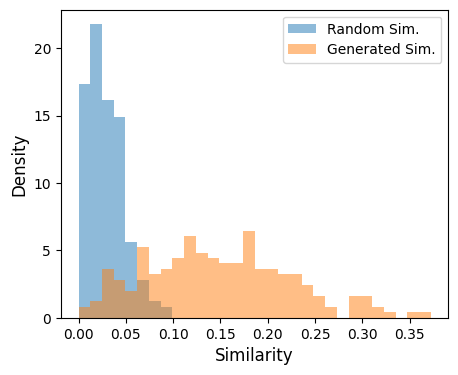

In [82]:
bin_edges = np.histogram_bin_edges(np.concatenate([random_similarity_averages, ce_similarity_averages]), bins=30)
plt.xlabel('Similarity', fontsize=12)
plt.ylabel('Density', fontsize=12)
# plt.title('Distribution of Similarity', fontsize=12)

plt.savefig("plots/Distribution of Similarity.png", dpi=300)
plt.show()

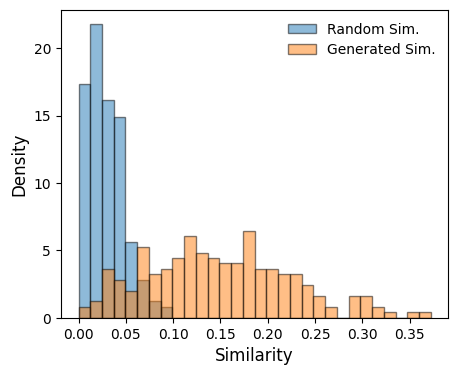

In [84]:
import matplotlib.pyplot as plt
import numpy as np

# random_similarity_averages, ce_similarity_averages = [...], [...]

plt.figure(figsize=(5, 4))
bin_edges = np.histogram_bin_edges(np.concatenate([random_similarity_averages, ce_similarity_averages]), bins=30)
plt.hist(random_similarity_averages, bins=bin_edges, alpha=0.5, label='Random Sim.', color='#1f77b4', edgecolor='black', density=True)
plt.hist(ce_similarity_averages, bins=bin_edges, alpha=0.5, label='Generated Sim.', color='#ff7f0e', edgecolor='black', density=True)
plt.xlabel('Similarity', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.savefig("plots/Distribution_of_Similarity.png", dpi=300)
plt.show()

# Similarity

In [64]:
import numpy as np
total_stds = []
generated_similarities = []
random_similarities = []

# Process each guidance scale separately to conserve memory
for scale, hidden_tensors in hidden_tensors_dict.items():
    # Move hidden tensors to device in smaller chunks if necessary
    hidden_tensors = hidden_tensors.to(device)
    # print("hidden_tensors", hidden_tensors.shape)
    gen_sim, rand_sim = evaluate_similarity(sub, hidden_tensors, img_features_test_all[::])
    
    ce_similarity_averages = [np.mean(gen_sim[idx*10 : (idx+1)*10]) for idx in range(len(gen_sim) // 10)]
    ce_similarity_stds = [np.std(gen_sim[idx*10 : (idx+1)*10]) for idx in range(len(gen_sim) // 10)]
    ce_similarity_total = np.mean(ce_similarity_averages)


    # print("Generated similarity total", ce_similarity_total)
    generated_similarities.append(ce_similarity_total)
    total_stds.append(np.mean(ce_similarity_stds))


    random_similarity_averages = [np.mean(rand_sim[idx*10 : (idx+1)*10]) for idx in range(len(rand_sim) // 10)]
    random_similarity_total = np.mean(random_similarity_averages)
    
    # print("Random similarity total", random_similarity_total)
    random_similarities.append(random_similarity_total)

In [ ]:
total_stds

In [65]:
generated_similarities
# random_similarities

[0.11898302,
 0.13678102,
 0.14674087,
 0.17593193,
 0.20011821,
 0.20987843,
 0.22353934,
 0.20868622,
 0.1782341,
 0.14810728]

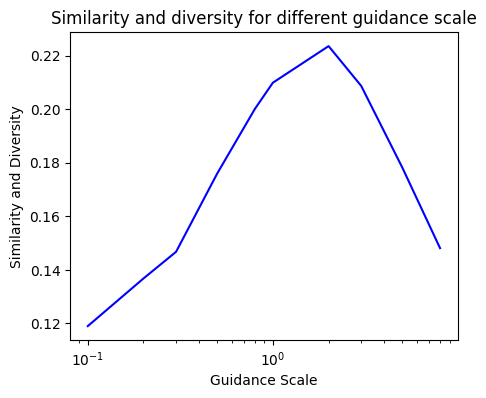

In [66]:
plt.errorbar(guidance_scales, generated_similarities,   color='blue', ecolor='lightblue', elinewidth=3, capsize=5)
plt.xscale('log')
plt.xlabel('Guidance Scale')
plt.ylabel('Similarity and Diversity')
plt.title('Similarity and diversity for different guidance scale')

plt.show()

# Diversity

In [67]:
# Function to compute the In-batch Image Diversity metric
def in_batch_image_diversity(batch_images):
    similarity_sum = 0.0
    for i in range(1, n):
        for j in range(i):
            similarity_sum += calculate_cosine_similarity(batch_images[i], batch_images[j]).item()
    diversity = 1 - (2 * similarity_sum) / (n * (n - 1)) if n > 1 else 1
    return diversity

def compute_overall_diversity(hidden_tensors_dict, device):
    diversity_scores = []
    divers = []
    for scale, hidden_tensors in hidden_tensors_dict.items():
        batch_diversities = []
            batch_images_normed = batch_images / batch_images.norm(dim=-1, keepdim=True)
            diversity_score = in_batch_image_diversity(batch_images_normed)
            batch_diversities.append(diversity_score)
        divers.append(batch_diversities)    
        scale_diversity = sum(batch_diversities) / len(batch_diversities) if batch_diversities else 0
        
        diversity_scores.append((scale, scale_diversity))
    
    return diversity_scores, divers
diversity_scores, divers = compute_overall_diversity(hidden_tensors_dict, device)

In [68]:
divers

[[0.781351856307851,
  0.8164024690373076,
  0.8126269763335585,
  0.8340659300486246,
  0.7873296467794313,
  0.8296863400480814,
  0.8237487414075683,
  0.777589613199234,
  0.8008256268325366,
  0.8363904307699865,
  0.7611334083808793,
  0.8151791457914643,
  0.8350645423970289,
  0.8101508564626178,
  0.7646004490140412,
  0.8152874508251746,
  0.8491066825472646,
  0.8240647131991055,
  0.8270749491924005,
  0.8242177453305986,
  0.8105022650212049,
  0.8313962748481167,
  0.834080651784057,
  0.8115428419576751,
  0.8220095005817711,
  0.8470785283483565,
  0.7981561357776323,
  0.8109817024320364,
  0.8031819895737701,
  0.8238180363136861,
  0.8376293674732248,
  0.8273896986204716,
  0.8420506795040436,
  0.8376398885001739,
  0.8182501369621604,
  0.8382347458559606,
  0.8366445531033807,
  0.843339005485177,
  0.7587460518711143,
  0.7715602585011059,
  0.7856527365744114,
  0.8110104114645057,
  0.8406345449801949,
  0.8207360301580694,
  0.839246541613506,
  0.84178280691

In [69]:
stds_diver = np.std(divers, axis=1)

In [70]:
guidance_scales = [scale for scale, _ in diversity_scores]
diversity_values = [score for _, score in diversity_scores]
diversity_values

[0.8118266983560655,
 0.7930407484500812,
 0.766616701500228,
 0.6927890085677659,
 0.5836306537141791,
 0.5243044935489565,
 0.31315767629775737,
 0.21532822600007046,
 0.13963774859242975,
 0.10346496942308216]

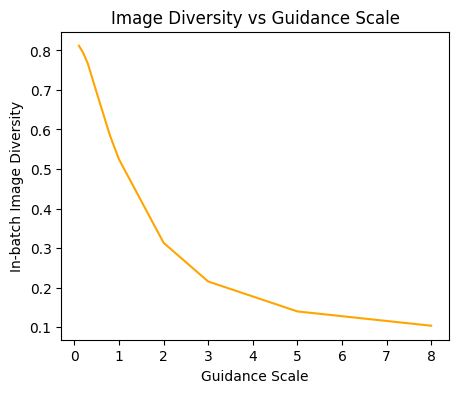

In [71]:

# Plotting
plt.figure(figsize=(5, 4))
# plt.plot(guidance_scales, diversity_values, '-o', color='darkblue')
plt.errorbar(guidance_scales, diversity_values,   color='orange', ecolor='lightblue', elinewidth=3, capsize=5)
plt.xlabel('Guidance Scale')
plt.ylabel('In-batch Image Diversity')
plt.title('Image Diversity vs Guidance Scale')
# plt.grid(True)
plt.show()

# both

In [72]:
# total_sims = np.asarray(total_sims)
# total_sims.shape
# stds = np.std(total_sims, axis=1)
# stds

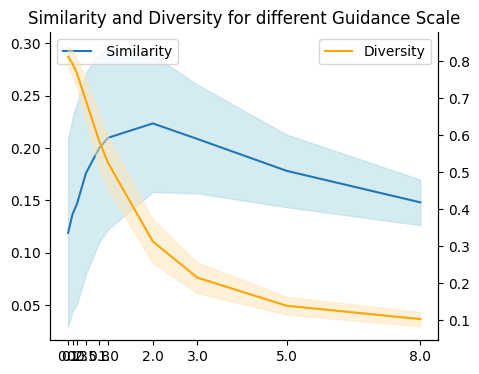

In [73]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 4))
plt.title('Similarity and Diversity for different Guidance Scale', fontsize=12)
# Creating dual axes
ax1 = plt.gca()  # Getting the current axis
ax2 = ax1.twinx()  # Creating a second y-axis

# Plotting image similarity
ax1.errorbar(guidance_scales, generated_similarities, elinewidth=4, capsize=7, label=' Similarity')
ax1.fill_between(guidance_scales, np.array(generated_similarities) - np.array(total_stds), np.array(generated_similarities) + np.array(total_stds), color='lightblue', alpha=0.5)
# Plotting image diversity
ax2.errorbar(guidance_scales, diversity_values, color='orange', elinewidth=4, capsize=7, label='Diversity')
ax2.fill_between(guidance_scales, np.array(diversity_values) - np.array(stds_diver), np.array(diversity_values) + np.array(stds_diver), color='moccasin', alpha=0.5)

# ax1.set_xlabel('Guidance Scale', fontsize=14)
# Set x-axis ticks
ax1.set_xticks(guidance_scales)
# Set x-axis tick labels to the guidance scales, formatted as strings
ax1.set_xticklabels([str(scale) for scale in guidance_scales])

# ax1.set_title('Similarity and Diversity for different Guidance Scale')
# Hide the top and right border of the plot
# ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
# ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

# Adding legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.savefig("plots/Similarity and Diversity for different Guidance Scale.png", dpi=300)
plt.show()

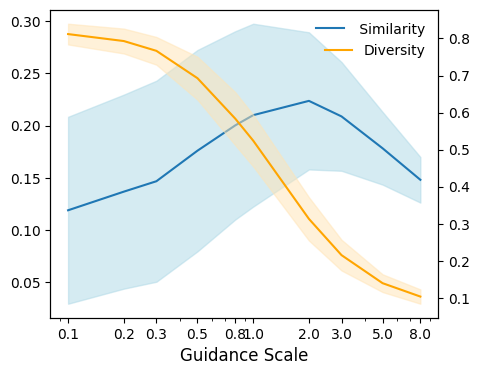

In [74]:
plt.figure(figsize=(5, 4))
# plt.title('Similarity and Diversity for different Guidance Scale', fontsize=14)
# Creating dual axes
ax1 = plt.gca()
ax2 = ax1.twinx()

# Plotting image similarity with error bar
# ax1.errorbar(guidance_scales, generated_similarities, yerr=total_stds, elinewidth=2, capsize=5, label='Similarity', fmt='-o')
ax1.errorbar(guidance_scales, generated_similarities, elinewidth=4, capsize=7, label=' Similarity')
ax1.fill_between(guidance_scales, np.array(generated_similarities) - np.array(total_stds), np.array(generated_similarities) + np.array(total_stds), color='lightblue', alpha=0.5)

# Plotting image diversity with error bar
# ax2.errorbar(guidance_scales, diversity_values, yerr=stds_diver, elinewidth=2, capsize=5, label='Diversity', fmt='-o', color='orange')
ax2.errorbar(guidance_scales, diversity_values, color='orange', elinewidth=4, capsize=7, label='Diversity')
ax2.fill_between(guidance_scales, np.array(diversity_values) - np.array(stds_diver), np.array(diversity_values) + np.array(stds_diver), color='moccasin', alpha=0.5)

# Set x-axis label
ax1.set_xlabel('Guidance Scale', fontsize=12)

# Set x-axis scale to log
ax1.set_xscale('log')

# Set x-axis ticks
ax1.set_xticks(guidance_scales)
# Set x-axis tick labels to the guidance scales, formatted as strings
ax1.set_xticklabels([str(scale) for scale in guidance_scales])

# Hide the top and right border of the plot
# ax1.spines['top'].set_visible(False)
# ax2.spines['top'].set_visible(False)

# Adding legends without borders
ax1_legend = ax1.legend(loc='upper right', frameon=False)
ax2_legend = ax2.legend(loc='upper right', frameon=False)

# Move the second legend to prevent overlap
ax2_legend.get_frame().set_alpha(None)  # This makes the legend background transparent
ax2_legend.get_frame().set_facecolor((0, 0, 0, 0))  # This makes the legend background transparent

# Adjust the position of the second legend
ax2_legend.set_bbox_to_anchor((1, 0.93))
plt.savefig("plots/Similarity and Diversity for different Guidance Scale.png", dpi=300)
plt.show()

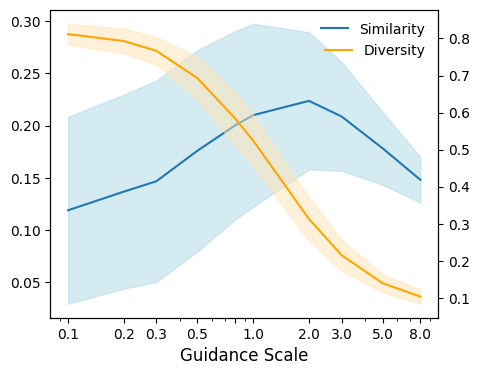

In [90]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(5, 4))
ax1 = plt.gca()
ax2 = ax1.twinx()

ax1.errorbar(guidance_scales, generated_similarities, elinewidth=4, capsize=7, label='Similarity')
ax1.fill_between(guidance_scales, np.array(generated_similarities) - np.array(total_stds), np.array(generated_similarities) + np.array(total_stds), color='lightblue', alpha=0.5)
ax2.errorbar(guidance_scales, diversity_values, color='orange', elinewidth=4, capsize=7, label='Diversity')
ax2.fill_between(guidance_scales, np.array(diversity_values) - np.array(stds_diver), np.array(diversity_values) + np.array(stds_diver), color='moccasin', alpha=0.5)

ax1.set_xlabel('Guidance Scale', fontsize=12)
ax1.set_xscale('log')

ax1.set_xticks(guidance_scales)
ax1.set_xticklabels([str(scale) if scale != 0.8 else '' for scale in guidance_scales])

ax1_legend = ax1.legend(loc='upper right', frameon=False)
ax2_legend = ax2.legend(loc='upper right', frameon=False)
# Move the second legend to prevent overlap
ax2_legend.get_frame().set_alpha(None)  # This makes the legend background transparent
ax2_legend.get_frame().set_facecolor((0, 0, 0, 0))  # This makes the legend background transparent
# Adjust the position of the second legend
ax2_legend.set_bbox_to_anchor((1, 0.93))

plt.savefig("plots/Similarity_and_Diversity_for_different_Guidance_Scale.png", dpi=300)
plt.show()

In [75]:
diversity_values

[0.8118266983560655,
 0.7930407484500812,
 0.766616701500228,
 0.6927890085677659,
 0.5836306537141791,
 0.5243044935489565,
 0.31315767629775737,
 0.21532822600007046,
 0.13963774859242975,
 0.10346496942308216]

In [76]:
# import torch
# import random

# def evaluation(sub, hidden, loader, device, text_features_all, img_features_all, k):    
#     text_features_all = text_features_all.to(device).float()
#     img_features_all = img_features_all.to(device).float()
#     total_loss = 0
#     correct = 0
#     total = 0
#     top5_correct = 0
#     # all_labels set creation seems redundant as it's the range of text_features_all.size(0), 
#     # but kept for consistency with your original code
#     all_labels = set(range(text_features_all.size(0)))

#     with torch.no_grad():        
#         for batch_idx, (eeg_data, labels, text, text_features, img, img_features) in enumerate(loader):            
#             text_features = text_features.to(device).float()
#             labels = labels.to(device)
#             img_features = img_features.to(device).float()
            
#             for idx, label in enumerate(labels):
#                 # Select k-1 classes not including the correct one
#                 possible_classes = list(all_labels - {label.item()})
#                 selected_classes = random.sample(possible_classes, k-1) + [label.item()]
#                 selected_img_features = img_features_all[selected_classes]
                
#                 # Compute logits
#                 logits_img = hidden[idx] @ selected_img_features.T
#                 logits_single = logits_img
                
#                 # Top-1 accuracy
#                 predicted_label = selected_classes[torch.argmax(logits_single).item()]
#                 if predicted_label == label.item():
#                     correct += 1
                
#                 # Top-5 accuracy
#                 _, top5_pred = torch.topk(logits_single, 5)
#                 top5_pred_labels = [selected_classes[int(i)] for i in top5_pred.cpu().numpy().flatten()]
#                 if label.item() in top5_pred_labels:
#                     top5_correct += 1
                
#                 total += 1

#     top1_accuracy = correct / total
#     top5_accuracy = top5_correct / total
#     return top1_accuracy, top5_accuracy, labels

# config = {
# "data_path": "/home/ldy/Workspace/THINGS/Preprocessed_data_250Hz",
# "project": "train_pos_img_text_rep",
# "entity": "sustech_rethinkingbci",
# "name": "lr=3e-4_img_pos_pro_eeg",
# "lr": 3e-4,
# "epochs": 50,
# "batch_size": 1024,
# "logger": True
# }


# data_path = config['data_path']
# test_dataset = EEGDataset(data_path, subjects= ['sub-08'], train=False)
# test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False, num_workers=0)

# text_features_test_all = test_dataset.text_features
# img_features_test_all = test_dataset.img_features


# # eeg_model.load_state_dict(torch.load("/home/ldy/Workspace/Reconstruction/models/contrast/sub-08/01-30_00-44/40.pth"))
# sub = 'sub-08'
# top1_accuracy, top5_accuracy, labels = evaluation(sub, hidden, test_loader, device, text_features_test_all, img_features_test_all,k=200)
# print(f" - Test top-1: {top1_accuracy:.4f}, Test top-5: {top5_accuracy:.4f}")

In [ ]:
# import pandas as pd

# results = {
#     "Subject": [sub],
#     "Top-1 Accuracy": [top1_accuracy],
#     "Top-5 Accuracy": [top5_accuracy]
# }

# df_results = pd.DataFrame(results)

# save_path = "outputs_prior_diffusion_retrieval/results_all.csv"

# df_results.to_csv(save_path, index=False)

# print(f"Results saved to {save_path}")